## Lab 7, Group 1
### Names: Hailey DeMark, Deborah Park, Karis Park
### Student IDs: 48869449, 48878679, 48563429

Dataset:

## Preparation (3 points total)
* [1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  
    * For this lab, we chose a text dataset made up of SMS messages. Each message is labeled as either "spam" (unwanted messages) or "ham" (normal messages). The dataset is already split into two parts: a training set with 957 messages and a test set with 125 messages. Each row in the data has a message and a label. We will turn the labels into numbers — "spam" will be 1 and "ham" will be 0 — so we can use them in a machine learning model. To prepare the messages, we will use a tokenizer to turn each message into a list of numbers. Then we will make all messages the same length by adding padding, so they can be used in a neural network.

* [1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
    * We used the Keras tokenizer to convert the text into sequences of integers, where each unique word is mapped to a unique index. This numerical representation makes it easier for the model to process and train efficiently. Since our goal is to determine whether a message is spam or not, preserving the order of words is essential—word position can influence meaning. The tokenizer allows us to maintain this word order through indexed sequences. Additionally, we applied padding to ensure all sequences have the same length, which provides consistent input dimensions and improves the model’s processing efficiency.

* [1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.
    * We used a shuffle-and-split method to divide the dataset. This approach was chosen because it is efficient and helps ensure a balanced distribution of spam and non-spam messages across the training and validation sets. By randomly mixing the data before splitting, we avoid having large sections dominated by only one class, which can lead to biased or ineffective models. This improves the model's ability to accurately predict whether a given message is spam or not. For evaluation, we selected the F1-score as our primary metric. Since the dataset is imbalanced—with significantly more spam than non-spam messages—the F1-score provides a better measure than accuracy by balancing both precision and recall. This is especially important in real-world scenarios: if important legitimate emails are mistakenly flagged as spam, they might be lost or ignored, causing real harm. On the other hand, misclassifying spam as legitimate is usually just inconvenient. Therefore, it's crucial to strike a balance between catching as much spam as possible while minimizing false positives.ng data. This helps us get a better idea of how the model performs, especially when the number of spam and normal messages are very different.

In [ ]:
#!pip3 install tensorflow-hub

import tensorflow_hub as hub
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import MultiHeadAttention, Flatten, Input, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
# Load data
dfTrain = pd.read_csv('SMS_train.csv', encoding='cp1252')
dfTest = pd.read_csv('SMS_test.csv', encoding='cp1252')

# Combine the datasets
dfCombined = pd.concat([dfTrain, dfTest], ignore_index=True)

dfCombined.head()
dfCombined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        1082 non-null   int64 
 1   Message_body  1082 non-null   object
 2   Label         1082 non-null   object
dtypes: int64(1), object(2)
memory usage: 25.5+ KB


In [28]:
# Download the stopwords resource if not already done
nltk.download('stopwords')

# Get the English stopwords set
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Simpler tokenization using regular expressions
def simple_tokenizer(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and tokenize by splitting on spaces
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Apply the simple tokenizer to the Message_body column
dfCombined['Processed_Message'] = dfCombined['Message_body'].apply(simple_tokenizer).apply(remove_stopwords)

# Encode the Labels into binary format (Spam=1, Non-Spam=0)
label_encoder = LabelEncoder()
dfCombined['Encoded_Label'] = label_encoder.fit_transform(dfCombined['Label'])

# Display a sample of the processed dataset
dfCombined[['Message_body', 'Processed_Message', 'Label', 'Encoded_Label']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deborahpark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Message_body,Processed_Message,Label,Encoded_Label
0,Rofl. Its true to its name,"[rofl, true, name]",Non-Spam,0
1,The guy did some bitching but I acted like i'd...,"[guy, bitching, acted, like, interested, buyin...",Non-Spam,0
2,"Pity, * was in mood for that. So...any other s...","[pity, mood, suggestions]",Non-Spam,0
3,Will ü b going to esplanade fr home?,"[ü, b, going, esplanade, fr, home]",Non-Spam,0
4,This is the 2nd time we have tried 2 contact u...,"[2nd, time, tried, 2, contact, u, u, 750, poun...",Spam,1


In [29]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfCombined['Processed_Message'].apply(lambda x: ' '.join(x)))

# Convert text to integer sequences
sequences = tokenizer.texts_to_sequences(dfCombined['Processed_Message'].apply(lambda x: ' '.join(x)))

# Pad sequences
padded_sequences = pad_sequences(sequences, padding='post')

# Vocabulary size for the embedding layer
vocab_size = len(tokenizer.word_index) + 1

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, dfCombined['Encoded_Label'], test_size=0.2, random_state=42
)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

## Modeling (6 points total)
* [3 points] Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8203 - loss: 0.5638 - val_accuracy: 0.7861 - val_loss: 0.4978
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8105 - loss: 0.4471 - val_accuracy: 0.7861 - val_loss: 0.4578
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8456 - loss: 0.3137 - val_accuracy: 0.9306 - val_loss: 0.2282
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9776 - loss: 0.1052 - val_accuracy: 0.9480 - val_loss: 0.1207
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9949 - loss: 0.0207 - val_accuracy: 0.9653 - val_loss: 0.1005
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9711 - val_loss: 0.1053
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9653 - val_loss: 0.1121
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9711 - val_loss: 0.

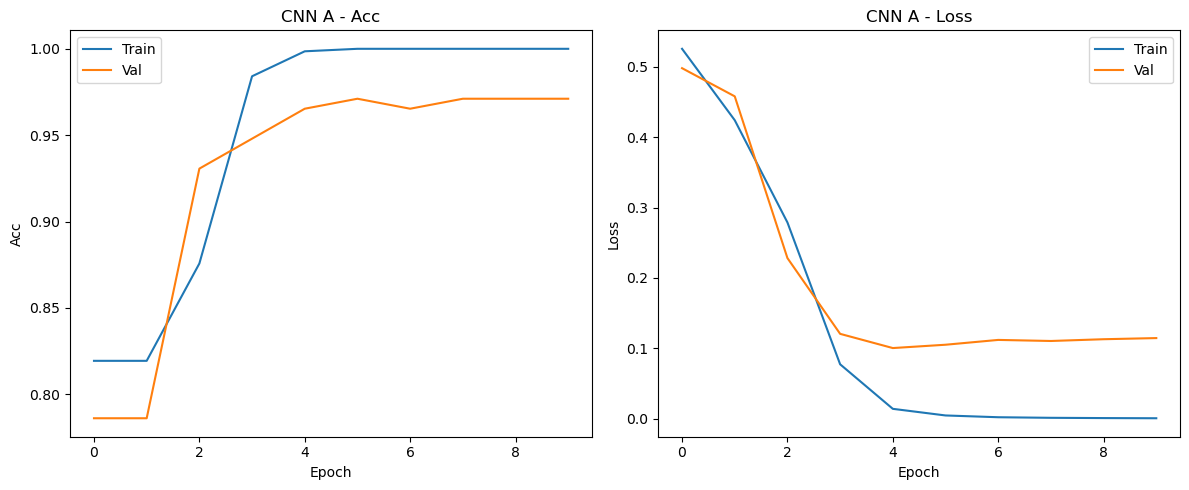

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
F1 A: 0.9014084507042254
Conf A:
 [[178   3]
 [  4  32]]
Prec A: 0.9142857142857143
Rec A: 0.8888888888888888
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7792 - loss: 0.5357 - val_accuracy: 0.8208 - val_loss: 0.2921
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9656 - loss: 0.1490 - val_accuracy: 0.9538 - val_loss: 0.1405
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9976 - loss: 0.0367 - val_accuracy: 0.9538 - val_loss: 0.1218
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9995 - loss: 0.0109 - val_accuracy: 0.9538 - val_loss: 0.1226
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.9595 - val_loss: 0.1170
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9595 - val_loss: 0.1178
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accur

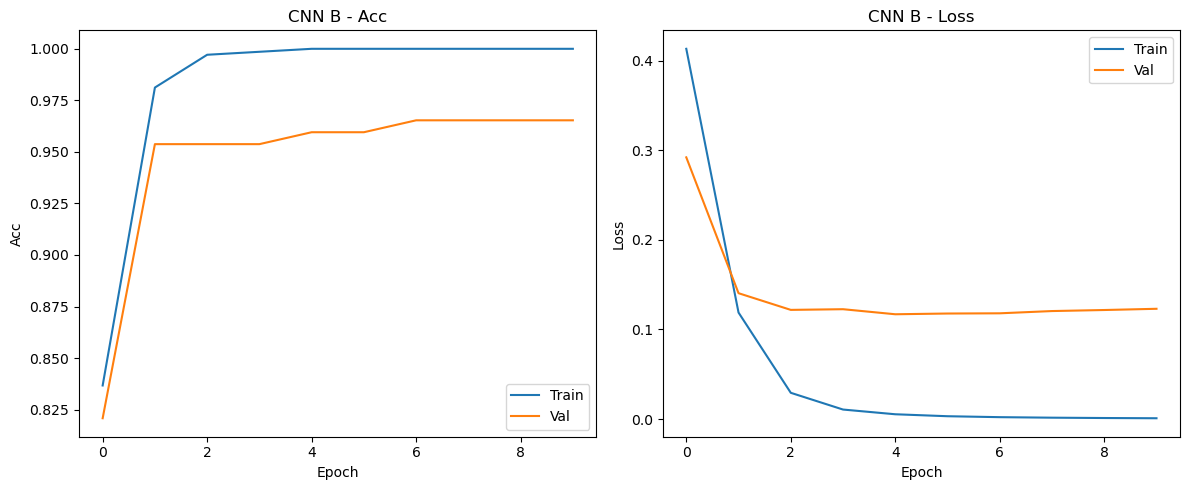

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
F1 B: 0.9577464788732394
Conf B:
 [[180   1]
 [  2  34]]
Prec B: 0.9714285714285714
Rec B: 0.9444444444444444


In [30]:
# CNN
# Plot training results
def plot_metrics(hist, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train')
    plt.plot(hist.history['val_accuracy'], label='Val')
    plt.title(f'{title} - Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train')
    plt.plot(hist.history['val_loss'], label='Val')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Input
inp = Input(shape=(X_train.shape[1],))
emb = Embedding(input_dim=vocab_size, output_dim=128, input_length=X_train.shape[1])(inp)

# CNN A
conv1 = Conv1D(128, 5, activation='relu')(emb)
drop1 = Dropout(0.4)(conv1)
pool1 = GlobalMaxPooling1D()(conv1)
dense1 = Dense(10, activation='relu')(pool1)
out1 = Dense(1, activation='sigmoid')(dense1)

model1 = Model(inputs=inp, outputs=out1)
model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train A
hist1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
plot_metrics(hist1, "CNN A")

# Eval A
pred1 = (model1.predict(X_test) > 0.5).astype(int)
print("F1 A:", f1_score(y_test, pred1))
print("Conf A:\n", confusion_matrix(y_test, pred1))
print("Prec A:", precision_score(y_test, pred1))
print("Rec A:", recall_score(y_test, pred1))

# CNN B
conv2 = Conv1D(64, 3, activation='relu')(emb)
drop2 = Dropout(0.4)(conv2)
pool2 = GlobalMaxPooling1D()(conv2)
dense2 = Dense(20, activation='relu')(pool2)
out2 = Dense(1, activation='sigmoid')(dense2)

model2 = Model(inputs=inp, outputs=out2)
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train B
hist2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
plot_metrics(hist2, "CNN B")

# Eval B
pred2 = (model2.predict(X_test) > 0.5).astype(int)
print("F1 B:", f1_score(y_test, pred2))
print("Conf B:\n", confusion_matrix(y_test, pred2))
print("Prec B:", precision_score(y_test, pred2))
print("Rec B:", recall_score(y_test, pred2))


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8104 - loss: 0.5239 - val_accuracy: 0.7861 - val_loss: 0.4708
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8094 - loss: 0.4346 - val_accuracy: 0.7861 - val_loss: 0.3828
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8981 - loss: 0.2481 - val_accuracy: 0.9711 - val_loss: 0.1239
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9911 - loss: 0.0306 - val_accuracy: 0.9653 - val_loss: 0.1505
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9951 - loss: 0.0223 - val_accuracy: 0.9711 - val_loss: 0.1158
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9968 - loss: 0.0087 - val_accuracy: 0.9769 - val_loss: 0.1407
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9949 - loss: 0.0066 - val_accuracy: 0.9769 - val_loss: 0.1405
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.6728e-04 - val_accuracy: 0.9769

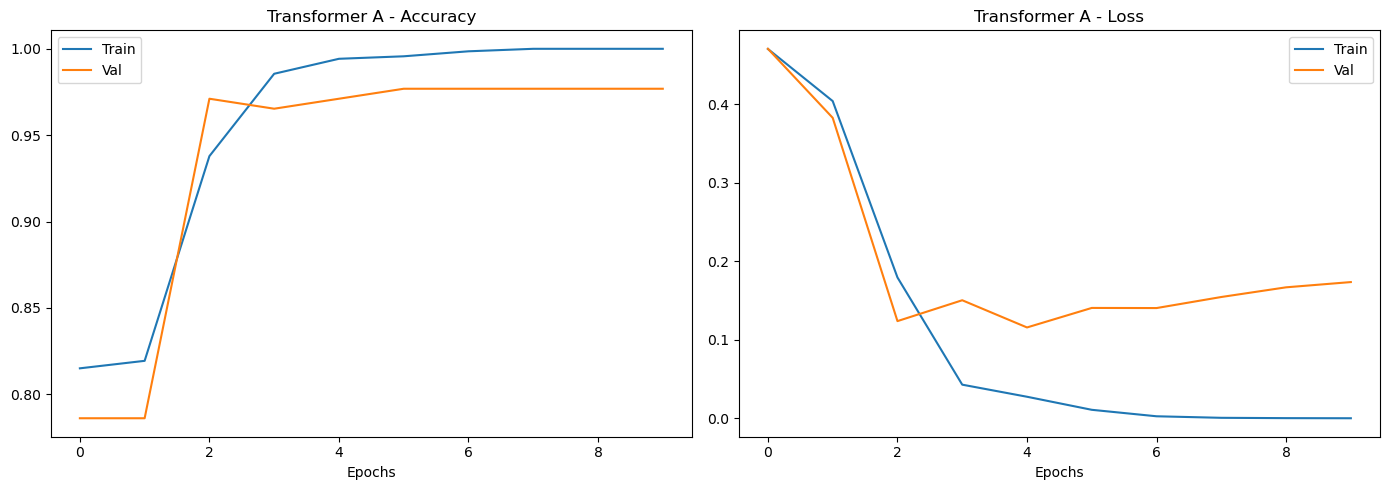

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.7087 - loss: 0.5511 - val_accuracy: 0.7861 - val_loss: 0.4801
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.8263 - loss: 0.4087 - val_accuracy: 0.7861 - val_loss: 0.3957
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8952 - loss: 0.2353 - val_accuracy: 0.9653 - val_loss: 0.1963
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.9663 - loss: 0.1143 - val_accuracy: 0.9595 - val_loss: 0.1258
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9946 - loss: 0.0257 - val_accuracy: 0.9595 - val_loss: 0.2138
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9936 - loss: 0.0202 - val_accuracy: 0.9538 - val_loss: 0.4518
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.9979 - loss: 0.0093 - val_accuracy: 0.9769 - val_loss: 0.2416
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.

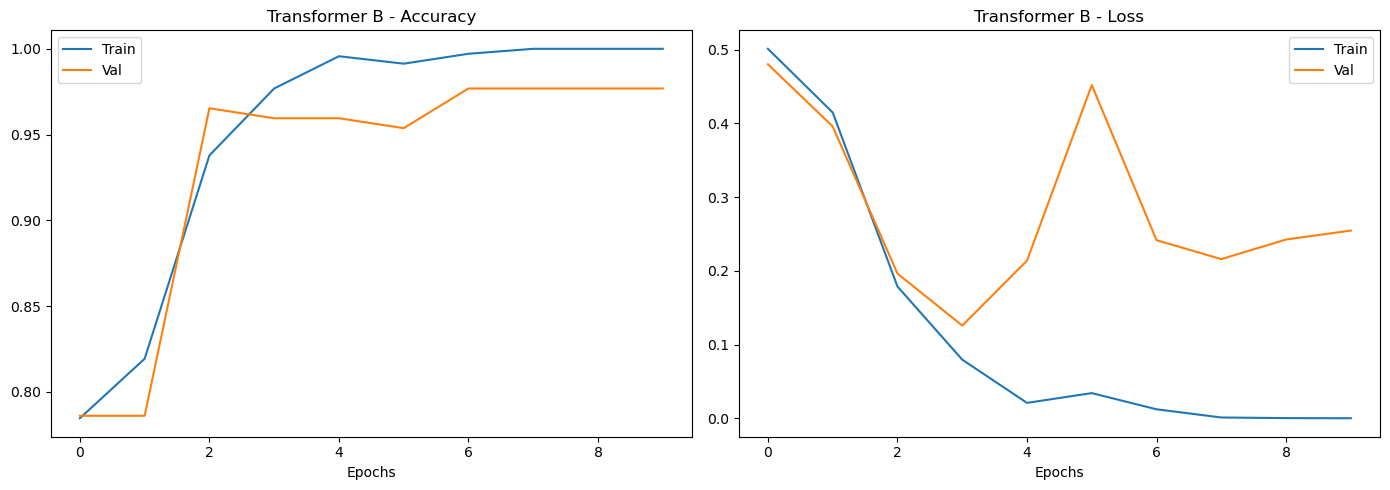

In [36]:
# Transformer

# Prepare 
train_texts = [str(t) for t in (X_train.tolist() if isinstance(X_train, np.ndarray) else X_train)]
test_texts = [str(t) for t in (X_test.tolist() if isinstance(X_test, np.ndarray) else X_test)]

# Tokenize
tok = Tokenizer()
tok.fit_on_texts(train_texts)
train_seq = tok.texts_to_sequences(train_texts)
test_seq = tok.texts_to_sequences(test_texts)
vocab = len(tok.word_index) + 1
max_len = max(len(seq) for seq in train_seq)

# Pad
X_train_pad = pad_sequences(train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(test_seq, maxlen=max_len, padding='post')

# Transformer A
def transformer_a(heads=4, dim=100):
    inp = Input(shape=(max_len,))
    emb = Embedding(input_dim=vocab, output_dim=dim)(inp)
    attn = MultiHeadAttention(num_heads=heads, key_dim=dim)(emb, emb)
    flat = Flatten()(attn)
    dense = Dense(10, activation='relu')(flat)
    out = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_a = transformer_a()
hist_a = model_a.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict & evaluate
pred_a = (model_a.predict(X_test_pad) > 0.5).astype(int)
print("F1 A:", f1_score(y_test, pred_a))
print("Conf A:\n", confusion_matrix(y_test, pred_a))

# Plot A
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(hist_a.history['accuracy'], label='Train')
ax[0].plot(hist_a.history['val_accuracy'], label='Val')
ax[0].set_title('Transformer A - Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(hist_a.history['loss'], label='Train')
ax[1].plot(hist_a.history['val_loss'], label='Val')
ax[1].set_title('Transformer A - Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.tight_layout()
plt.show()

# Transformer B
def transformer_b(heads=6, dim=200):
    inp = Input(shape=(max_len,))
    emb = Embedding(input_dim=vocab, output_dim=dim)(inp)
    attn = MultiHeadAttention(num_heads=heads, key_dim=dim)(emb, emb)
    flat = Flatten()(attn)
    dense = Dense(10, activation='relu')(flat)
    out = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_b = transformer_b()
hist_b = model_b.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict & evaluate B
pred_b = (model_b.predict(X_test_pad) > 0.5).astype(int)
print("F1 B:", f1_score(y_test, pred_b))
print("Conf B:\n", confusion_matrix(y_test, pred_b))

# Plot B
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(hist_b.history['accuracy'], label='Train')
ax[0].plot(hist_b.history['val_accuracy'], label='Val')
ax[0].set_title('Transformer B - Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(hist_b.history['loss'], label='Train')
ax[1].plot(hist_b.history['val_loss'], label='Val')
ax[1].set_title('Transformer B - Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.tight_layout()
plt.show()

* [1 points] Using the best parameters and architecture from the Transformer in the previous step, add a second Multi-headed self attention layer to your network. That is, the input to the second attention layer should be the output sequence of the first attention layer.  Visualize the performance of training and validation sets versus the training iterations, showing that the model converged.. 

In [32]:
# code

* [2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the models you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

In [33]:
# code

## Exceptional Work (1 points total)
* You have free reign to provide additional analyses.
* One idea (required for 7000 level students to do one of these options):
    * Use the pre-trained ConceptNet Numberbatch embedding and compare to pre-trained GloVe. Which method is better for your specific application? 

In [34]:
# code